In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import gc
from tqdm.auto import tqdm 
import joblib
from datetime import timedelta, date



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet
/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet
/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train_multi.parquet


In [2]:
# def feature_extraction(df, istrain = True, step_rolling = 5):
#     ids = df['series_id'].unique(maintain_order = True)
    
#     if (istrain):
#         df = df.with_columns(
#             awake = df["awake"].cast(pl.Int8)
#         )

    
#     df = df.with_columns(        
#         year = (df["timestamp"].str.slice(0,4).cast(pl.Int16) - 2000).cast(pl.UInt8),
#         month = df["timestamp"].str.slice(5,2).cast(pl.Int8),
#         day = df["timestamp"].str.slice(8,2).cast(pl.Int8),
#         hour = df["timestamp"].str.slice(11,2).cast(pl.Int8),
#         minute = df["timestamp"].str.slice(14,2).cast(pl.Int8),
# #         second = df["timestamp"].str.slice(17,2).cast(pl.Int8),
#         time_zone = df["timestamp"].str.slice(-5,3).cast(pl.Int32),
        
#         enmo =  (pl.col('enmo')*1000).cast(pl.UInt16),
        
#         weekday = train["timestamp"].str.slice(0,10).str.to_date().dt.weekday()
        
#     )
    
#     signal_awake = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.208 * np.pi) ** 24))
#     signal_onset = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.555 * np.pi) ** 24))
#     df = df.with_columns(
#         (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))
#         .apply(signal_onset.get, return_dtype=pl.Float32)
#         .alias("signal_onset")
#     )    
#     df = df.with_columns(
#         (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))
#         .apply(signal_awake.get, return_dtype=pl.Float32)
#         .alias("signal_awake")
#     )

#     df = df.with_columns(lids = np.maximum(0., tmp['enmo'] - 0.02))
#     df = df.with_columns(
#         lids = pl.col('lids').rolling_sum(121, center=True, min_periods=1)
#     )
#     df = df.with_columns(lids = 100 / (pl.col('lids') + 1))
#     df = df.with_columns(
#         lids = pl.col('lids').rolling_mean(361, center=True, min_periods=1).cast(pl.Float32)
#     )
#     gc.collect()
#     return df

# train = feature_extraction(train)
# train
# # list(train['signal_onset'][:10])

In [3]:
def feature_extraction(df, istrain = True, step_rolling = 5):    
    ids = df['series_id'].unique(maintain_order = True)
    
    if (istrain):
        df = df.with_columns(
            awake = df["awake"].cast(pl.Int8)
        )

    df = df.with_columns(
        lids = np.maximum(0., df['enmo'] - 0.02),
        year = (df["timestamp"].str.slice(0,4).cast(pl.Int16) - 2000).cast(pl.UInt8),
        month = df["timestamp"].str.slice(5,2).cast(pl.Int8),
        day = df["timestamp"].str.slice(8,2).cast(pl.Int8),
        hour = df["timestamp"].str.slice(11,2).cast(pl.Int8),
        minute = df["timestamp"].str.slice(14,2).cast(pl.Int8),
        second = df["timestamp"].str.slice(17,2).cast(pl.Int8),
        time_zone = df["timestamp"].str.slice(-5,3).cast(pl.Int32),
        weekday = df["timestamp"].str.slice(0,10).str.to_date().dt.weekday(),

        enmo =  (pl.col('enmo')*1000).cast(pl.UInt16),
        )
    
    signal_awake = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.208 * np.pi) ** 24))
    signal_onset = dict(zip(range(1440), np.sin(np.linspace(0, np.pi, 1440) + 0.555 * np.pi) ** 24))
    df = df.with_columns(
        (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))
        .apply(signal_onset.get, return_dtype=pl.Float32)
        .alias("signal_onset"),
        (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))
        .apply(signal_awake.get, return_dtype=pl.Float32)
        .alias("signal_awake"),
        df["hour"].cast(pl.Int32)*60 + df["minute"].cast(pl.Int32).alias('hour_minute')
    )
    
    features, feature_cols = [], []

    for mins in [1, 3, 5, 30, 60*2, 60*8] :
        for var in ['enmo', 'anglez'] :
            features += [
                pl.col(var).rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_mean'),
                pl.col(var).rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_max'),
                pl.col(var).rolling_std(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_std')
            ]
            feature_cols += [ 
                f'{var}_{mins}m_mean', f'{var}_{mins}m_max', f'{var}_{mins}m_std'
            ]
            # Getting first variations
            features += [
                (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
                (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max'),
                (pl.col(var).diff().abs().rolling_std(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_std')
            ]
            feature_cols += [ 
                f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max', f'{var}_1v_{mins}m_std'
            ]
    # id_cols = ['series_id', 'step', 'timestamp']

    dict_ids2data = {}    
    for i in tqdm(range(len(ids))):
    # for i in range(2):
        print (i,': ', ids[i])
        dict_ids2data[ids[i]] = df.filter(pl.col("series_id") == ids[i])
        dict_ids2data[ids[i]] = dict_ids2data[ids[i]].with_columns(
            features,
            lids = pl.col('lids').rolling_sum(121, center=True, min_periods=1)
        )
                
        dict_ids2data[ids[i]] = dict_ids2data[ids[i]].with_columns(
            (100 / (pl.col('lids') + 1)).alias('lids'),
            pl.col("anglez").rolling_mean(window_size = step_rolling, center = True).cast(pl.Float32).alias(f'anglez_{step_rolling*5}s_smooth'),
            pl.col("enmo").rolling_mean(window_size = step_rolling, center = True).cast(pl.Float32).alias(f'enmo_{step_rolling*5}s_smooth')
        )
        
        dict_ids2data[ids[i]] = dict_ids2data[ids[i]].fill_null(strategy="forward").fill_null(strategy="backward")
        
        dict_ids2data[ids[i]] = dict_ids2data[ids[i]].with_columns(
            lids = pl.col('lids').rolling_mean(361, center=True, min_periods=1).cast(pl.Float32),
            anglez_lag_5s = dict_ids2data[ids[i]]['anglez'].shift(periods=1),
            anglez_lag_10s = dict_ids2data[ids[i]]['anglez'].shift(periods=2),
            anglez_lag_15s = dict_ids2data[ids[i]]['anglez'].shift(periods=3),
            anglez_lag_30s = dict_ids2data[ids[i]]['anglez'].shift(periods=6),
            anglez_lag_60s = dict_ids2data[ids[i]]['anglez'].shift(periods=12),
            anglez_smooth_lag_30s = dict_ids2data[ids[i]][f'anglez_{step_rolling*5}s_smooth'].cast(pl.Float32).shift(periods=6),
            anglez_smooth_lag_60s = dict_ids2data[ids[i]][f'anglez_{step_rolling*5}s_smooth'].cast(pl.Float32).shift(periods=12),

            enmo_lag_5s = dict_ids2data[ids[i]]['enmo'].shift(periods=1),
            enmo_lag_10s = dict_ids2data[ids[i]]['enmo'].shift(periods=2),
            enmo_lag_15s = dict_ids2data[ids[i]]['enmo'].shift(periods=3),
            enmo_lag_30s = dict_ids2data[ids[i]]['enmo'].shift(periods=6),
            enmo_lag_60s = dict_ids2data[ids[i]]['enmo'].shift(periods=12),
            enmo_smooth_lag_30s = dict_ids2data[ids[i]][f'enmo_{step_rolling*5}s_smooth'].cast(pl.Float32).shift(periods=6),
            enmo_smooth_lag_60s = dict_ids2data[ids[i]][f'enmo_{step_rolling*5}s_smooth'].cast(pl.Float32).shift(periods=12)
        )
        
        dict_ids2data[ids[i]] = dict_ids2data[ids[i]].fill_null(strategy="forward").fill_null(strategy="backward")

        
    df = pl.concat([i for i in dict_ids2data.values()], rechunk=True)

    del dict_ids2data
    gc.collect()

    return df



In [4]:
%%time
train = pl.read_parquet('/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet')
train.head()

CPU times: user 1.82 s, sys: 649 ms, total: 2.47 s
Wall time: 1.79 s


series_id,step,timestamp,anglez,enmo,awake
str,u32,str,f32,f32,i64
"""08db4255286f""",0,"""2018-11-05T10:…",-30.845301,0.0447,1
"""08db4255286f""",1,"""2018-11-05T10:…",-34.181801,0.0443,1
"""08db4255286f""",2,"""2018-11-05T10:…",-33.877102,0.0483,1
"""08db4255286f""",3,"""2018-11-05T10:…",-34.282101,0.068,1
"""08db4255286f""",4,"""2018-11-05T10:…",-34.385799,0.0768,1


In [5]:
train_fe = feature_extraction(train)

train_fe

/tmp/ipykernel_26/2147898270.py:26: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))
/tmp/ipykernel_26/2147898270.py:29: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))


  0%|          | 0/35 [00:00<?, ?it/s]

0 :  08db4255286f
1 :  0a96f4993bd7
2 :  0cfc06c129cc
3 :  1087d7b0ff2e
4 :  10f8bc1f7b07
5 :  18b61dd5aae8
6 :  29c75c018220
7 :  3452b878e596
8 :  349c5562ee2c
9 :  3664fe9233f9
10 :  483d6545417f
11 :  55a47ff9dc8a
12 :  5acc9d63b5fd
13 :  5f94bb3e1bed
14 :  655f19eabf1e
15 :  67f5fc60e494
16 :  72bbd1ac3edf
17 :  76237b9406d5
18 :  7822ee8fe3ec
19 :  89bd631d1769
20 :  8e32047cbc1f
21 :  939932f1822d
22 :  9ee455e4770d
23 :  a9a2f7fac455
24 :  a9e5f5314bcb
25 :  af91d9a50547
26 :  b364205aba43
27 :  c535634d7dcd
28 :  c6788e579967
29 :  c68260cc9e8f
30 :  ca730dbf521d
31 :  d150801f3145
32 :  d25e479ecbb7
33 :  d515236bdeec
34 :  d5e47b94477e


series_id,step,timestamp,anglez,enmo,awake,lids,year,month,day,hour,minute,second,time_zone,weekday,signal_onset,signal_awake,enmo_1m_mean,enmo_1m_max,enmo_1m_std,enmo_1v_1m_mean,enmo_1v_1m_max,enmo_1v_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_std,anglez_1v_1m_mean,anglez_1v_1m_max,anglez_1v_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_std,enmo_1v_3m_mean,enmo_1v_3m_max,enmo_1v_3m_std,anglez_3m_mean,anglez_3m_max,…,enmo_1v_120m_mean,enmo_1v_120m_max,enmo_1v_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_std,anglez_1v_120m_mean,anglez_1v_120m_max,anglez_1v_120m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_std,enmo_1v_480m_mean,enmo_1v_480m_max,enmo_1v_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_std,anglez_1v_480m_mean,anglez_1v_480m_max,anglez_1v_480m_std,anglez_25s_smooth,enmo_25s_smooth,anglez_lag_5s,anglez_lag_10s,anglez_lag_15s,anglez_lag_30s,anglez_lag_60s,anglez_smooth_lag_30s,anglez_smooth_lag_60s,enmo_lag_5s,enmo_lag_10s,enmo_lag_15s,enmo_lag_30s,enmo_lag_60s,enmo_smooth_lag_30s,enmo_smooth_lag_60s
str,u32,str,f32,u16,i8,f32,u8,i8,i8,i32,i8,i8,i32,u32,f32,f32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,…,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u16,u16,u16,u16,u16,f32,f32
"""08db4255286f""",0,"""2018-11-05T10:…",-30.845301,44,1,14.129221,18,11,5,600,0,0,-4,1,4.6365e-26,0.149748,55,76,13,114,250,106,33,30,1,9,33,13,57,107,17,150,560,158,31,24,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
"""08db4255286f""",1,"""2018-11-05T10:…",-34.181801,44,1,14.119147,18,11,5,600,0,5,-4,1,4.6365e-26,0.149748,62,107,23,188,560,205,33,30,1,15,44,18,57,107,17,154,560,154,30,24,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
"""08db4255286f""",2,"""2018-11-05T10:…",-33.877102,48,1,14.109452,18,11,5,600,0,10,-4,1,4.6365e-26,0.149748,62,107,21,222,560,208,32,30,1,13,44,17,58,107,16,147,560,153,30,24,…,206,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-34.181801,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
"""08db4255286f""",3,"""2018-11-05T10:…",-34.282101,68,1,14.09982,18,11,5,600,0,15,-4,1,4.6365e-26,0.149748,61,107,20,215,560,194,32,30,1,14,44,17,58,107,16,140,560,152,30,24,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,94,-34.330482,57.400002,-33.877102,-34.181801,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,48,44,44,44,44,56.0,56.0
"""08db4255286f""",4,"""2018-11-05T10:…",-34.385799,76,1,14.090398,18,11,5,600,0,20,-4,1,4.6365e-26,0.149748,59,107,20,193,560,193,33,30,1,14,44,15,58,107,15,137,560,149,30,24,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-33.596802,70.0,-34.282101,-33.877102,-34.181801,-30.845301,-30.845301,-33.514423,-33.514423,68,48,44,44,44,56.0,56.0
"""08db4255286f""",5,"""2018-11-05T10:…",-34.925598,51,1,14.081073,18,11,5,600,0,25,-4,1,4.6365e-26,0.149748,61,107,19,207,560,187,33,30,1,15,44,15,58,107,15,135,560,146,30,24,…,207,1230,194,27,16,3,18,96,15,74,992,85,262,7160,451,21,89,43,42,1315,93,-32.92326,73.199997,-34.385799,-34.282101,-33.877102,-30.845301,-30.845301,-33.514423,-33.514423,76,68,48,44,44,56.0,56.0
"""08db4255286f""",6,"""2018-11-05T10:…",-30.513399,107,1,14.071533,18,11,5,600,0,30,-4,1,4.6365e-26,0.149748,62,107,19,195,560,181,32,30,1,15,44,14,57,107,15,140,560,144,29,24,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-32.64296,69.199997,-34.925598,-34.385799,-34.282101,-30.845301,-30.845301,-33.514423,-33.514423,51,76,68,44,44,56.0,56.0
"""08db4255286f""",7,"""2018-11-05T10:…",-30.509399,64,1,14.06176,18,11,5,600,0,3

In [6]:
c_types = train_fe.dtypes
c_name = train_fe.columns

print(len(c_name))
print('\n'.join(["{}\t-\t{}".format(str(a_), str(b_)) for a_, b_ in zip(c_name, c_types)]))

105
series_id	-	Utf8
step	-	UInt32
timestamp	-	Utf8
anglez	-	Float32
enmo	-	UInt16
awake	-	Int8
lids	-	Float32
year	-	UInt8
month	-	Int8
day	-	Int8
hour	-	Int32
minute	-	Int8
second	-	Int8
time_zone	-	Int32
weekday	-	UInt32
signal_onset	-	Float32
signal_awake	-	Float32
enmo_1m_mean	-	UInt16
enmo_1m_max	-	UInt16
enmo_1m_std	-	UInt16
enmo_1v_1m_mean	-	UInt32
enmo_1v_1m_max	-	UInt32
enmo_1v_1m_std	-	UInt32
anglez_1m_mean	-	UInt16
anglez_1m_max	-	UInt16
anglez_1m_std	-	UInt16
anglez_1v_1m_mean	-	UInt32
anglez_1v_1m_max	-	UInt32
anglez_1v_1m_std	-	UInt32
enmo_3m_mean	-	UInt16
enmo_3m_max	-	UInt16
enmo_3m_std	-	UInt16
enmo_1v_3m_mean	-	UInt32
enmo_1v_3m_max	-	UInt32
enmo_1v_3m_std	-	UInt32
anglez_3m_mean	-	UInt16
anglez_3m_max	-	UInt16
anglez_3m_std	-	UInt16
anglez_1v_3m_mean	-	UInt32
anglez_1v_3m_max	-	UInt32
anglez_1v_3m_std	-	UInt32
enmo_5m_mean	-	UInt16
enmo_5m_max	-	UInt16
enmo_5m_std	-	UInt16
enmo_1v_5m_mean	-	UInt32
enmo_1v_5m_max	-	UInt32
enmo_1v_5m_std	-	UInt32
anglez_5m_mean	-	UInt

In [7]:
%%time
test_raw = pl.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet')
test_raw.head()

CPU times: user 0 ns, sys: 4.72 ms, total: 4.72 ms
Wall time: 9.97 ms


series_id,step,timestamp,anglez,enmo
str,u32,str,f32,f32
"""038441c925bb""",0,"""2018-08-14T15:…",2.6367,0.0217
"""038441c925bb""",1,"""2018-08-14T15:…",2.6368,0.0215
"""038441c925bb""",2,"""2018-08-14T15:…",2.637,0.0216
"""038441c925bb""",3,"""2018-08-14T15:…",2.6368,0.0213
"""038441c925bb""",4,"""2018-08-14T15:…",2.6368,0.0215


In [8]:
test_fe = feature_extraction(test_raw, False)

test_fe

/tmp/ipykernel_26/2147898270.py:26: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))
/tmp/ipykernel_26/2147898270.py:29: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  (pl.col("hour").cast(pl.Int32)*60 + pl.col("minute").cast(pl.Int32))


  0%|          | 0/3 [00:00<?, ?it/s]

0 :  038441c925bb
1 :  03d92c9f6f8a
2 :  0402a003dae9


series_id,step,timestamp,anglez,enmo,lids,year,month,day,hour,minute,second,time_zone,weekday,signal_onset,signal_awake,enmo_1m_mean,enmo_1m_max,enmo_1m_std,enmo_1v_1m_mean,enmo_1v_1m_max,enmo_1v_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_std,anglez_1v_1m_mean,anglez_1v_1m_max,anglez_1v_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_std,enmo_1v_3m_mean,enmo_1v_3m_max,enmo_1v_3m_std,anglez_3m_mean,anglez_3m_max,anglez_3m_std,…,enmo_1v_120m_mean,enmo_1v_120m_max,enmo_1v_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_std,anglez_1v_120m_mean,anglez_1v_120m_max,anglez_1v_120m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_std,enmo_1v_480m_mean,enmo_1v_480m_max,enmo_1v_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_std,anglez_1v_480m_mean,anglez_1v_480m_max,anglez_1v_480m_std,anglez_25s_smooth,enmo_25s_smooth,anglez_lag_5s,anglez_lag_10s,anglez_lag_15s,anglez_lag_30s,anglez_lag_60s,anglez_smooth_lag_30s,anglez_smooth_lag_60s,enmo_lag_5s,enmo_lag_10s,enmo_lag_15s,enmo_lag_30s,enmo_lag_60s,enmo_smooth_lag_30s,enmo_smooth_lag_60s
str,u32,str,f32,u16,f32,u8,i8,i8,i32,i8,i8,i32,u32,f32,f32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,…,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u16,u16,u16,u16,u16,f32,f32
"""038441c925bb""",0,"""2018-08-14T15:…",2.6367,21,94.958038,18,8,14,930,30,0,-4,2,0.000003,3.0851e-9,21,21,0,0,0,0,2,2,0,0,0,0,21,22,0,2,10,4,2,3,0,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.63682,21.0,2.6367,2.6367,2.6367,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",1,"""2018-08-14T15:…",2.6368,21,94.958038,18,8,14,930,30,5,-4,2,0.000003,3.0851e-9,21,21,0,0,0,0,2,2,0,0,0,0,22,39,4,12,180,42,5,49,10,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.63682,21.0,2.6367,2.6367,2.6367,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",2,"""2018-08-14T15:…",2.637,21,94.958038,18,8,14,930,30,10,-4,2,0.000003,3.0851e-9,21,21,0,0,0,0,2,2,0,0,0,0,21,39,4,23,230,64,7,54,15,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.63682,21.0,2.6368,2.6367,2.6367,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",3,"""2018-08-14T15:…",2.6368,21,94.958038,18,8,14,930,30,15,-4,2,0.000003,3.0851e-9,21,22,0,1,10,3,2,2,0,0,1,0,21,39,4,23,230,62,9,54,16,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.63682,21.0,2.637,2.6368,2.6367,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",4,"""2018-08-14T15:…",2.6368,21,94.958038,18,8,14,930,30,20,-4,2,0.000003,3.0851e-9,21,22,0,2,10,4,2,3,0,0,2,1,21,39,4,25,230,62,11,67,20,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.6368,21.0,2.6368,2.637,2.6368,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",5,"""2018-08-14T15:…",2.6367,21,94.958038,18,8,14,930,30,25,-4,2,0.000003,3.0851e-9,21,22,0,3,10,4,2,3,0,0,3,1,21,39,4,30,230,64,14,68,23,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.63674,21.0,2.6368,2.6368,2.637,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",6,"""2018-08-14T15:…",2.6367,21,94.958038,18,8,14,930,30,30,-4,2,0.000003,3.0851e-9,21,22,0,3,10,5,2,3,0,0,3,1,20,39,5,35,230,68,15,68,23,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.66898,21.200001,2.6367,2.6368,2.6368,2.6367,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",7,"""2018-08-14T15:…",2.6367,21,94.958038,18,8,14,930,30,35,-4,2,0.000003,3.0851e-9,21,22,0,3,10,4,2,3,0,0,3,1,20,39,5,34,230,67,15,68,23,…,15,580,71,62,68,38,16,733,82,14,69,5,15,580,71,62,68,38,16,733,82,2.75856,21.200001,2.6367,2.6367,2.6368,2.6368,2.6367,2.63682,2.63682,21,21,21,21,21,21.0,21.0
"""038441c925bb""",8,"""2018-08-14T15:…",2.798,22,94.958038,18,8,14,930,30,40,-4,2,0.000003,3.0851e-9,21,22,0,3,10,4,2,3,0,0,3,1,19,39,6,34,230,66,16,68,22,…,15,

In [9]:
gc.collect()

0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


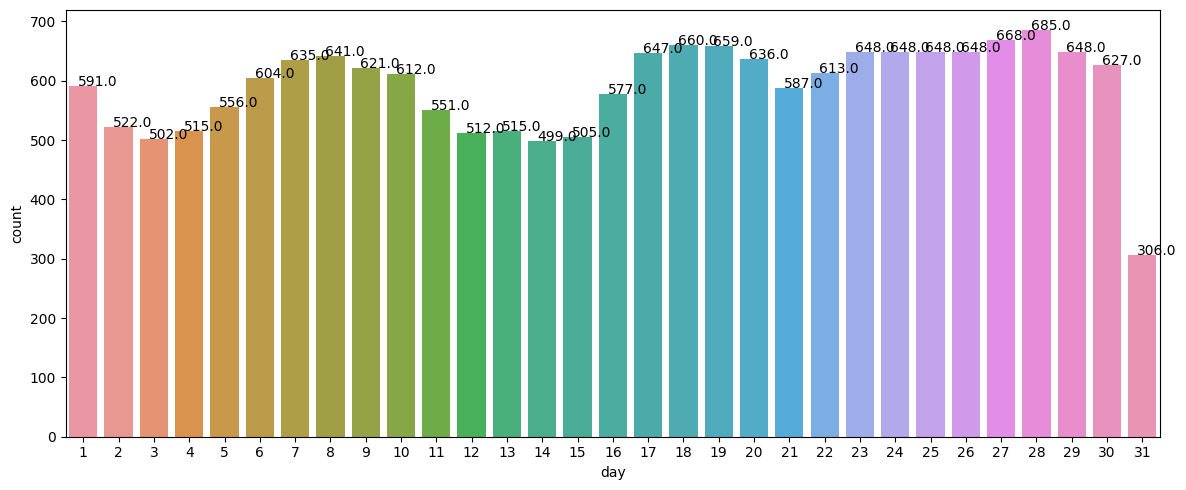

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [12.00, 5]
plt.rcParams["figure.autolayout"] = True

df = pd.DataFrame(dict(day=np.array(train_fe["day"].take_every(12*60))))

ax = sns.countplot(x="day", data=df)

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

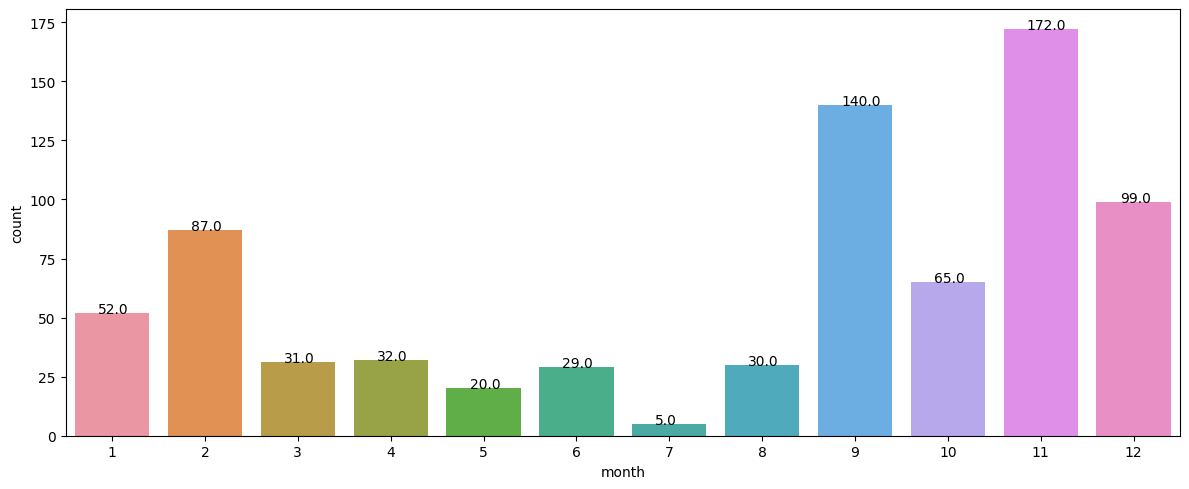

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = [12.00, 5]
plt.rcParams["figure.autolayout"] = True

df = pd.DataFrame(dict(month=np.array(train_fe["month"].take_every(12*60*24))))

ax = sns.countplot(x="month", data=df)

for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

plt.show()

In [12]:
%%time
test_fe.write_csv('test_series.csv')
test_fe.write_parquet('test_series.parquet')
train_fe.write_parquet('train_series.parquet')

CPU times: user 23.9 s, sys: 2.27 s, total: 26.2 s
Wall time: 26.1 s


In [13]:
# data_dtype = {
#         "series_id": "category",
#         "step": "uint32",
#         "timestamp": "str",
#         "anglez": "float32",
#         "enmo": "float32",
#     }
# data = pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet').astype(data_dtype, copy=False)

In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook__.ipynb
/kaggle/working/test_series.csv
/kaggle/working/test_series.parquet
/kaggle/working/train_series.parquet


In [15]:
import polars as pl
from tqdm.auto import tqdm 
import gc
gc.collect()

7872

In [16]:
data = pl.read_parquet('/kaggle/working/train_series.parquet')
data.head()

series_id,step,timestamp,anglez,enmo,awake,lids,year,month,day,hour,minute,second,time_zone,weekday,signal_onset,signal_awake,enmo_1m_mean,enmo_1m_max,enmo_1m_std,enmo_1v_1m_mean,enmo_1v_1m_max,enmo_1v_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_std,anglez_1v_1m_mean,anglez_1v_1m_max,anglez_1v_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_std,enmo_1v_3m_mean,enmo_1v_3m_max,enmo_1v_3m_std,anglez_3m_mean,anglez_3m_max,…,enmo_1v_120m_mean,enmo_1v_120m_max,enmo_1v_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_std,anglez_1v_120m_mean,anglez_1v_120m_max,anglez_1v_120m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_std,enmo_1v_480m_mean,enmo_1v_480m_max,enmo_1v_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_std,anglez_1v_480m_mean,anglez_1v_480m_max,anglez_1v_480m_std,anglez_25s_smooth,enmo_25s_smooth,anglez_lag_5s,anglez_lag_10s,anglez_lag_15s,anglez_lag_30s,anglez_lag_60s,anglez_smooth_lag_30s,anglez_smooth_lag_60s,enmo_lag_5s,enmo_lag_10s,enmo_lag_15s,enmo_lag_30s,enmo_lag_60s,enmo_smooth_lag_30s,enmo_smooth_lag_60s
str,u32,str,f32,u16,i8,f32,u8,i8,i8,i32,i8,i8,i32,u32,f32,f32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,…,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u16,u16,u16,u16,u16,f32,f32
"""08db4255286f""",0,"""2018-11-05T10:…",-30.845301,44,1,14.129221,18,11,5,600,0,0,-4,1,4.6365e-26,0.149748,55,76,13,114,250,106,33,30,1,9,33,13,57,107,17,150,560,158,31,24,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
"""08db4255286f""",1,"""2018-11-05T10:…",-34.181801,44,1,14.119147,18,11,5,600,0,5,-4,1,4.6365e-26,0.149748,62,107,23,188,560,205,33,30,1,15,44,18,57,107,17,154,560,154,30,24,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
"""08db4255286f""",2,"""2018-11-05T10:…",-33.877102,48,1,14.109452,18,11,5,600,0,10,-4,1,4.6365e-26,0.149748,62,107,21,222,560,208,32,30,1,13,44,17,58,107,16,147,560,153,30,24,…,206,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-34.181801,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
"""08db4255286f""",3,"""2018-11-05T10:…",-34.282101,68,1,14.09982,18,11,5,600,0,15,-4,1,4.6365e-26,0.149748,61,107,20,215,560,194,32,30,1,14,44,17,58,107,16,140,560,152,30,24,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,94,-34.330482,57.400002,-33.877102,-34.181801,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,48,44,44,44,44,56.0,56.0
"""08db4255286f""",4,"""2018-11-05T10:…",-34.385799,76,1,14.090398,18,11,5,600,0,20,-4,1,4.6365e-26,0.149748,59,107,20,193,560,193,33,30,1,14,44,15,58,107,15,137,560,149,30,24,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-33.596802,70.0,-34.282101,-33.877102,-34.181801,-30.845301,-30.845301,-33.514423,-33.514423,68,48,44,44,44,56.0,56.0


In [17]:
def split_train_test(df, n_train):
    ids = df['series_id'].unique(maintain_order = True)
    dict_ids2data = {}

    # for i in range(2):
    for i in tqdm(range(len(ids))):
        print (i,': ', ids[i])
        dict_ids2data[ids[i]] = df.filter(pl.col("series_id") == ids[i])

    train_ = pl.concat([i for i, i_id in zip(dict_ids2data.values(), range(len(ids))) if i_id <= n_train], rechunk=True)
    test_ = pl.concat([i for i, i_id in zip(dict_ids2data.values(), range(len(ids))) if i_id > n_train], rechunk=True)

    del dict_ids2data
    gc.collect()
    
    return train_, test_

def split_Xy_train(df):
    if ('step' in df.columns):
        df = df.drop("step")
    if ('series_id' in df.columns):
        df = df.drop("series_id")
    if ('timestamp' in df.columns):
        df = df.drop("timestamp")
    return df.drop("awake"), df['awake']

train, test = split_train_test(data, 30)

X_train, y_train = split_Xy_train(train)



  0%|          | 0/35 [00:00<?, ?it/s]

0 :  08db4255286f
1 :  0a96f4993bd7
2 :  0cfc06c129cc
3 :  1087d7b0ff2e
4 :  10f8bc1f7b07
5 :  18b61dd5aae8
6 :  29c75c018220
7 :  3452b878e596
8 :  349c5562ee2c
9 :  3664fe9233f9
10 :  483d6545417f
11 :  55a47ff9dc8a
12 :  5acc9d63b5fd
13 :  5f94bb3e1bed
14 :  655f19eabf1e
15 :  67f5fc60e494
16 :  72bbd1ac3edf
17 :  76237b9406d5
18 :  7822ee8fe3ec
19 :  89bd631d1769
20 :  8e32047cbc1f
21 :  939932f1822d
22 :  9ee455e4770d
23 :  a9a2f7fac455
24 :  a9e5f5314bcb
25 :  af91d9a50547
26 :  b364205aba43
27 :  c535634d7dcd
28 :  c6788e579967
29 :  c68260cc9e8f
30 :  ca730dbf521d
31 :  d150801f3145
32 :  d25e479ecbb7
33 :  d515236bdeec
34 :  d5e47b94477e


In [18]:
gc.collect()

0

In [19]:
X_train.head()

anglez,enmo,lids,year,month,day,hour,minute,second,time_zone,weekday,signal_onset,signal_awake,enmo_1m_mean,enmo_1m_max,enmo_1m_std,enmo_1v_1m_mean,enmo_1v_1m_max,enmo_1v_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_std,anglez_1v_1m_mean,anglez_1v_1m_max,anglez_1v_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_std,enmo_1v_3m_mean,enmo_1v_3m_max,enmo_1v_3m_std,anglez_3m_mean,anglez_3m_max,anglez_3m_std,anglez_1v_3m_mean,anglez_1v_3m_max,anglez_1v_3m_std,…,enmo_1v_120m_mean,enmo_1v_120m_max,enmo_1v_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_std,anglez_1v_120m_mean,anglez_1v_120m_max,anglez_1v_120m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_std,enmo_1v_480m_mean,enmo_1v_480m_max,enmo_1v_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_std,anglez_1v_480m_mean,anglez_1v_480m_max,anglez_1v_480m_std,anglez_25s_smooth,enmo_25s_smooth,anglez_lag_5s,anglez_lag_10s,anglez_lag_15s,anglez_lag_30s,anglez_lag_60s,anglez_smooth_lag_30s,anglez_smooth_lag_60s,enmo_lag_5s,enmo_lag_10s,enmo_lag_15s,enmo_lag_30s,enmo_lag_60s,enmo_smooth_lag_30s,enmo_smooth_lag_60s
f32,u16,f32,u8,i8,i8,i32,i8,i8,i32,u32,f32,f32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,…,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u16,u16,u16,u16,u16,f32,f32
-30.845301,44,14.129221,18,11,5,600,0,0,-4,1,4.6365e-26,0.149748,55,76,13,114,250,106,33,30,1,9,33,13,57,107,17,150,560,158,31,24,3,17,50,15,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
-34.181801,44,14.119147,18,11,5,600,0,5,-4,1,4.6365e-26,0.149748,62,107,23,188,560,205,33,30,1,15,44,18,57,107,17,154,560,154,30,24,3,16,50,15,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
-33.877102,48,14.109452,18,11,5,600,0,10,-4,1,4.6365e-26,0.149748,62,107,21,222,560,208,32,30,1,13,44,17,58,107,16,147,560,153,30,24,3,15,50,15,…,206,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-34.181801,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
-34.282101,68,14.09982,18,11,5,600,0,15,-4,1,4.6365e-26,0.149748,61,107,20,215,560,194,32,30,1,14,44,17,58,107,16,140,560,152,30,24,3,16,50,14,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,94,-34.330482,57.400002,-33.877102,-34.181801,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,48,44,44,44,44,56.0,56.0
-34.385799,76,14.090398,18,11,5,600,0,20,-4,1,4.6365e-26,0.149748,59,107,20,193,560,193,33,30,1,14,44,15,58,107,15,137,560,149,30,24,3,16,50,14,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-33.596802,70.0,-34.282101,-33.877102,-34.181801,-30.845301,-30.845301,-33.514423,-33.514423,68,48,44,44,44,56.0,56.0


In [20]:
y_train.head()

awake
i8
1
1
1
1
1
1
1
1
1


In [21]:
type(X_train)

polars.dataframe.frame.DataFrame

In [22]:
important_features =["anglez_1v_480m_max", "day", "month", "signal_onset", "anglez_1v_480m_mean", "signal_awake", "anglez_1v_120m_max", "anglez_480m_max", "anglez_480m_mean", "anglez_480m_std", "enmo_1v_480m_max", "anglez_1v_480m_std", "anglez_120m_max", "enmo_480m_max", "anglez_1v_120m_mean", "weekday", "enmo_120m_max", "anglez_1v_120m_std", "enmo_1v_120m_max", "enmo_1v_480m_std"]

In [23]:
len(important_features)

20

In [24]:
X_train

anglez,enmo,lids,year,month,day,hour,minute,second,time_zone,weekday,signal_onset,signal_awake,enmo_1m_mean,enmo_1m_max,enmo_1m_std,enmo_1v_1m_mean,enmo_1v_1m_max,enmo_1v_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_std,anglez_1v_1m_mean,anglez_1v_1m_max,anglez_1v_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_std,enmo_1v_3m_mean,enmo_1v_3m_max,enmo_1v_3m_std,anglez_3m_mean,anglez_3m_max,anglez_3m_std,anglez_1v_3m_mean,anglez_1v_3m_max,anglez_1v_3m_std,…,enmo_1v_120m_mean,enmo_1v_120m_max,enmo_1v_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_std,anglez_1v_120m_mean,anglez_1v_120m_max,anglez_1v_120m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_std,enmo_1v_480m_mean,enmo_1v_480m_max,enmo_1v_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_std,anglez_1v_480m_mean,anglez_1v_480m_max,anglez_1v_480m_std,anglez_25s_smooth,enmo_25s_smooth,anglez_lag_5s,anglez_lag_10s,anglez_lag_15s,anglez_lag_30s,anglez_lag_60s,anglez_smooth_lag_30s,anglez_smooth_lag_60s,enmo_lag_5s,enmo_lag_10s,enmo_lag_15s,enmo_lag_30s,enmo_lag_60s,enmo_smooth_lag_30s,enmo_smooth_lag_60s
f32,u16,f32,u8,i8,i8,i32,i8,i8,i32,u32,f32,f32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,…,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u16,u16,u16,u16,u16,f32,f32
-30.845301,44,14.129221,18,11,5,600,0,0,-4,1,4.6365e-26,0.149748,55,76,13,114,250,106,33,30,1,9,33,13,57,107,17,150,560,158,31,24,3,17,50,15,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
-34.181801,44,14.119147,18,11,5,600,0,5,-4,1,4.6365e-26,0.149748,62,107,23,188,560,205,33,30,1,15,44,18,57,107,17,154,560,154,30,24,3,16,50,15,…,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-30.845301,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
-33.877102,48,14.109452,18,11,5,600,0,10,-4,1,4.6365e-26,0.149748,62,107,21,222,560,208,32,30,1,13,44,17,58,107,16,147,560,153,30,24,3,15,50,15,…,206,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-34.181801,-30.845301,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,44,44,44,44,44,56.0,56.0
-34.282101,68,14.09982,18,11,5,600,0,15,-4,1,4.6365e-26,0.149748,61,107,20,215,560,194,32,30,1,14,44,17,58,107,16,140,560,152,30,24,3,16,50,14,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,94,-34.330482,57.400002,-33.877102,-34.181801,-30.845301,-30.845301,-30.845301,-33.514423,-33.514423,48,44,44,44,44,56.0,56.0
-34.385799,76,14.090398,18,11,5,600,0,20,-4,1,4.6365e-26,0.149748,59,107,20,193,560,193,33,30,1,14,44,15,58,107,15,137,560,149,30,24,3,16,50,14,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-33.596802,70.0,-34.282101,-33.877102,-34.181801,-30.845301,-30.845301,-33.514423,-33.514423,68,48,44,44,44,56.0,56.0
-34.925598,51,14.081073,18,11,5,600,0,25,-4,1,4.6365e-26,0.149748,61,107,19,207,560,187,33,30,1,15,44,15,58,107,15,135,560,146,30,24,3,15,50,14,…,207,1230,194,27,16,3,18,96,15,74,992,85,262,7160,451,21,89,43,42,1315,93,-32.92326,73.199997,-34.385799,-34.282101,-33.877102,-30.845301,-30.845301,-33.514423,-33.514423,76,68,48,44,44,56.0,56.0
-30.513399,107,14.071533,18,11,5,600,0,30,-4,1,4.6365e-26,0.149748,62,107,19,195,560,181,32,30,1,15,44,14,57,107,15,140,560,144,29,24,3,15,50,14,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-32.64296,69.199997,-34.925598,-34.385799,-34.282101,-30.845301,-30.845301,-33.514423,-33.514423,51,76,68,44,44,56.0,56.0
-30.509399,64,14.06176,18,11,5,600,0,35,-4,1,4.6365e-26,0.149748,63,107,18,190,560,174,32,29,1,15,44,14,57,107,15,140,560,141,29,18,4,17,65,17,…,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-32.700798,63.200001,-30.513399,-34.925598,-34.3857

In [25]:
print(X_train.columns)

['anglez', 'enmo', 'lids', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_zone', 'weekday', 'signal_onset', 'signal_awake', 'enmo_1m_mean', 'enmo_1m_max', 'enmo_1m_std', 'enmo_1v_1m_mean', 'enmo_1v_1m_max', 'enmo_1v_1m_std', 'anglez_1m_mean', 'anglez_1m_max', 'anglez_1m_std', 'anglez_1v_1m_mean', 'anglez_1v_1m_max', 'anglez_1v_1m_std', 'enmo_3m_mean', 'enmo_3m_max', 'enmo_3m_std', 'enmo_1v_3m_mean', 'enmo_1v_3m_max', 'enmo_1v_3m_std', 'anglez_3m_mean', 'anglez_3m_max', 'anglez_3m_std', 'anglez_1v_3m_mean', 'anglez_1v_3m_max', 'anglez_1v_3m_std', 'enmo_5m_mean', 'enmo_5m_max', 'enmo_5m_std', 'enmo_1v_5m_mean', 'enmo_1v_5m_max', 'enmo_1v_5m_std', 'anglez_5m_mean', 'anglez_5m_max', 'anglez_5m_std', 'anglez_1v_5m_mean', 'anglez_1v_5m_max', 'anglez_1v_5m_std', 'enmo_30m_mean', 'enmo_30m_max', 'enmo_30m_std', 'enmo_1v_30m_mean', 'enmo_1v_30m_max', 'enmo_1v_30m_std', 'anglez_30m_mean', 'anglez_30m_max', 'anglez_30m_std', 'anglez_1v_30m_mean', 'anglez_1v_30m_max', 'anglez_1v_30m_std

In [26]:
X_train = X_train.select(important_features)
X_train.head()

anglez_1v_480m_max,day,month,signal_onset,anglez_1v_480m_mean,signal_awake,anglez_1v_120m_max,anglez_480m_max,anglez_480m_mean,anglez_480m_std,enmo_1v_480m_max,anglez_1v_480m_std,anglez_120m_max,enmo_480m_max,anglez_1v_120m_mean,weekday,enmo_120m_max,anglez_1v_120m_std,enmo_1v_120m_max,enmo_1v_480m_std
u32,i8,i8,f32,u32,f32,u32,u16,u16,u16,u32,u32,u16,u16,u32,u32,u16,u32,u32,u32
1315,5,11,4.6365e-26,42,0.149748,96,89,21,43,7160,94,16,992,18,1,198,15,1230,451
1315,5,11,4.6365e-26,42,0.149748,96,89,21,43,7160,94,16,992,18,1,198,15,1230,451
1315,5,11,4.6365e-26,42,0.149748,96,89,21,43,7160,94,16,992,18,1,198,15,1230,451
1315,5,11,4.6365e-26,42,0.149748,96,89,21,43,7160,94,16,992,18,1,198,15,1230,451
1315,5,11,4.6365e-26,42,0.149748,96,89,21,43,7160,93,16,992,18,1,198,15,1230,451


In [27]:
from catboost import CatBoostClassifier, Pool

In [28]:
train_pool = Pool(X_train.to_pandas(), y_train.to_pandas())

In [29]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           loss_function = "Logloss",
                           learning_rate=0.01)

In [30]:
model.fit(train_pool,
          verbose=False)